## Art Dating

#### Students
- Zhenbang Chen
- Zhenjia Chen

### Setup

Importing packages and dependencies.  Load dataset for categorization.

In [1]:
import os
import copy
from PIL import Image
rootpath = "."

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.auto import tqdm
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2
Using the GPU!


### Model Initialization

In [3]:
def initialize_model(num_classes, resume_from=None):
    
    if resume_from:
        model_ft = models.resnet50(pretrained=False)
        
        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes)
        
        model_ft.load_state_dict(torch.load(resume_from))
        
        return model_ft
    else:
        # Model (nn.Module) to return
        # model_ft = models.resnet18(pretrained = false)
        model_ft = models.resnet50(pretrained=False)

        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes)

        return model_ft

### Tests

In [4]:
# Transform to apply to the data
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
# ])

# Transform to apply to the data for use with pretrained ResNet model
transform = torchvision.transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Get training data from directory
art_train = torchvision.datasets.ImageFolder(root="./data/art_culture_train",
                                                 transform=transform)

# Get validation data from directory
art_val = torchvision.datasets.ImageFolder(root="./data/art_culture_val",
                                               transform=transform)

# Get testing data from directory
art_test = torchvision.datasets.ImageFolder(root="./data/art_culture_test",
                                               transform=transform)

In [6]:
# Create random sampler
random_sampler = torch.utils.data.RandomSampler(data_source=art_train,
                                                replacement=True,
                                                num_samples=int(len(art_train)/10))

# Create batched dataloader
art_train_loader = torch.utils.data.DataLoader(dataset=art_train,
                                                   batch_size=8,
                                                   shuffle=True,
                                                   num_workers=4,
                                                   pin_memory=True)

# art_train_loader = torch.utils.data.DataLoader(dataset=art_train,
#                                                    batch_size=8,
#                                                    sampler=random_sampler,
#                                                    shuffle=False,
#                                                    num_workers=4,
#                                                    pin_memory=True)

art_val_loader = torch.utils.data.DataLoader(dataset=art_val,
                                                 batch_size=8,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

art_test_loader = torch.utils.data.DataLoader(dataset=art_test,
                                                 batch_size=8,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

### Initialization and Methods

In [ ]:
# Initialize model
# model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet50(pretrained=True)

# Set number of output classes
# model.conv1 = nn.Conv2d(in_channels=3,
#                         out_channels=64,
#                         kernel_size=(7,7),
#                         stride=(2,2),
#                         padding=(3,3),
#                         bias=False)

# in_features = model.fc.in_features
# out_features = 11
# model.fc = nn.Linear(in_features, out_features)

# model = model.to(device)

model = initialize_model(num_classes=11).to(device)

In [7]:
# Training method
def train(net, optim, criterion,train_loader):
    net.train()
    for image_cpu, label_cpu in tqdm(train_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Clear gradient
        optim.zero_grad()
        
        # Forward through the network
        output = net(image)
        
        # Loss and gradient
        loss = criterion(output, label)
        loss.backward()
        
        # Update paramters
        optim.step()

In [8]:
# Evaluation method
def evaluate(net, val_loader, top_n=1):
    total = 0
    correct = 0
    net.eval()
    
    for image_cpu, label_cpu in tqdm(val_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        tiled_labels = torch.stack([label for _ in range(top_n)], dim=1) 

        
        # Don't track gradients for performance in evaluation
        with torch.no_grad():
            # Get prediction with forward pass
#             prediction = net(image).argmax(dim=-1)
            
            # Get the indices of the top_n predictions
            prediction = net(image).topk(k=top_n, dim=-1)[1]
            
            # Total number in batch
            total += image.size(0)
            
            # Number correct in batch
#             correct += (prediction == label).sum().item()
            # Number correct in batch
            correct += (prediction == tiled_labels).sum().item()
            
    return correct/total

In [9]:
# Validation method
def validate(net, optim, criterion, val_loader):
    total = 0
    running_loss = 0
    correct = 0
    net.eval()
    
    for image_cpu, label_cpu in tqdm(val_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Clear gradient
        optim.zero_grad()
        
        # Don't track gradients for performance in validation
        with torch.no_grad():
            # Forward through the network
            output = net(image)
            
            # Get prediction with forward pass
            prediction = output.argmax(dim=-1)

            # Loss and gradient
            loss = criterion(output, label)
            
            # Total number in batch
            total += image.size(0)
            
            # Accumulate loss
            running_loss += loss.item()
            
            # Number correct in batch
            correct += (prediction == label).sum().item()
            
    return running_loss/total, correct/total

### Training

In [ ]:
# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Create criterion
criterion = torch.nn.CrossEntropyLoss()

# Create scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=4, gamma=0.1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                  mode="min",
#                                                  factor=0.2,
#                                                  patience=1,
#                                                  verbose=True,
#                                                  threshold=0.01)

In [ ]:
# Start training
num_epochs = 15

print("start")

best_state_dict = {}
best_val_acc = 0
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))
#     val_acc = evaluate(model, art_val_loader) * 100
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_state_dict = copy.deepcopy(model.state_dict())
    
    train(model, optimizer, criterion, art_train_loader)
    val_loss, val_acc = validate(model, optimizer, criterion, art_val_loader)
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = copy.deepcopy(model.state_dict())
    
    print("Val Loss - Epoch {}: {}".format(epoch, val_loss))
    print("Val Acc - Epoch {}: {}%".format(epoch, val_acc))
    
    if epoch % 4 == 0 and epoch != 0:
        torch.save(best_state_dict, "./models/art_culture_temp_epoch" + str(epoch))
    
print("Done! {}%".format(evaluate(model, art_val_loader) * 100))

In [ ]:
# Save model
torch.save(best_state_dict, "./models/art_culture_steplr001_step4_gamma01_epoch15_scratch")

### Testing

In [17]:
# Load the model to test
model = initialize_model(num_classes=11,
                         resume_from="./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30").to(device)

test_acc = evaluate(net=model, val_loader=art_test_loader, top_n=2)
print("Done!", test_acc)


Done! 0.8640483383685801


### Visualize Activations

In [60]:
import cv2
from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL.Image

In [186]:
def generate_featuremap_unit(resnet,unit_id,im_input):
    #Extract activation from model
    #TODO: remove the last 2 layers of resnet 
    model_cut = nn.Sequential(*(list(resnet.children())[:-2]))

    # Mark the model as being used for inference
    model_cut.eval()
    # Crop the image
    im = transform(im_input).to(device)
    # Place the image into a batch of size 1, and use the model to get an intermediate representation
    out = model_cut(im.unsqueeze(0))
    # Print the shape of our representation
    print(out.size())
    # Extract the only result from this batch, and take just the `unit_id`th channel
#     out_final = out.squeeze()[unit_id]

    out_sums = out.squeeze().sum(dim=(1,2), keepdim=True)
    out_sums = torch.where(out_sums != 0, out_sums, torch.ones(out_sums.size()).to(device))
    out_final = (out.squeeze() / out_sums).sum(dim=0)
    
#     out_final = out.squeeze().sum(dim=0)
    
#     print(out_final.size())
    print(out_final)
    
    # Return this channel
    return out_final

In [196]:
def visualize_featuremap(im_input,feature_map,alpha=0):
    # Normalize to [0..1], with a little leeway (0.9999) in case feature_map has 0 range
    feature_map = feature_map/(feature_map.max()+1e-10)
    # Convert to numpy (detach() just seperates a tensor from the gradient)
    feat_numpy = feature_map.detach().cpu().numpy()
    # Resize the feature map to our original image size (our strided conv layers reduce the size of the image)
    feat_numpy = cv2.resize(feat_numpy,(im_input.shape[1],im_input.shape[0]))
    # Invert to make the heatmap look more natural
    map_t = 1-feat_numpy
    # Add an extra dimension to make this a [H,W,C=1] image 
    feat_numpy = np.expand_dims(feat_numpy, axis=2)
    
    # Convert to image (UINT8 from 0-255)
    map_t = 255*map_t
    map_t = map_t.astype(np.uint8)
    # Use a color map to change this from BW to a nice color
    map_t = cv2.applyColorMap(map_t, cv2.COLORMAP_JET)
    # Combine the heatmap with the original image so you can see which section of the image is activated
    im_final = np.multiply((alpha*im_input + (1-alpha)*map_t), feat_numpy) + np.multiply(im_input, 1-feat_numpy)
    # Return final visualization
    return im_final

In [82]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

torch.Size([1, 2048, 7, 7])
tensor([[34.8267, 26.3300, 21.4772, 12.7212, 12.1640, 14.8856, 21.4105],
        [47.5210, 36.5029, 25.0344, 15.4981, 14.6577, 22.8156, 28.3783],
        [44.7660, 36.6191, 24.0433, 22.7027, 22.2323, 25.2814, 29.1667],
        [48.6267, 43.5387, 36.0837, 39.2448, 40.3488, 39.4729, 30.2749],
        [50.1015, 55.4277, 54.7897, 60.1064, 50.9542, 56.6792, 50.2881],
        [48.5602, 56.8966, 60.0629, 62.5372, 58.0461, 64.1406, 61.8920],
        [44.5721, 53.7803, 52.4983, 74.8414, 75.2254, 69.9926, 67.9822]],
       device='cuda:0', grad_fn=<SumBackward1>)


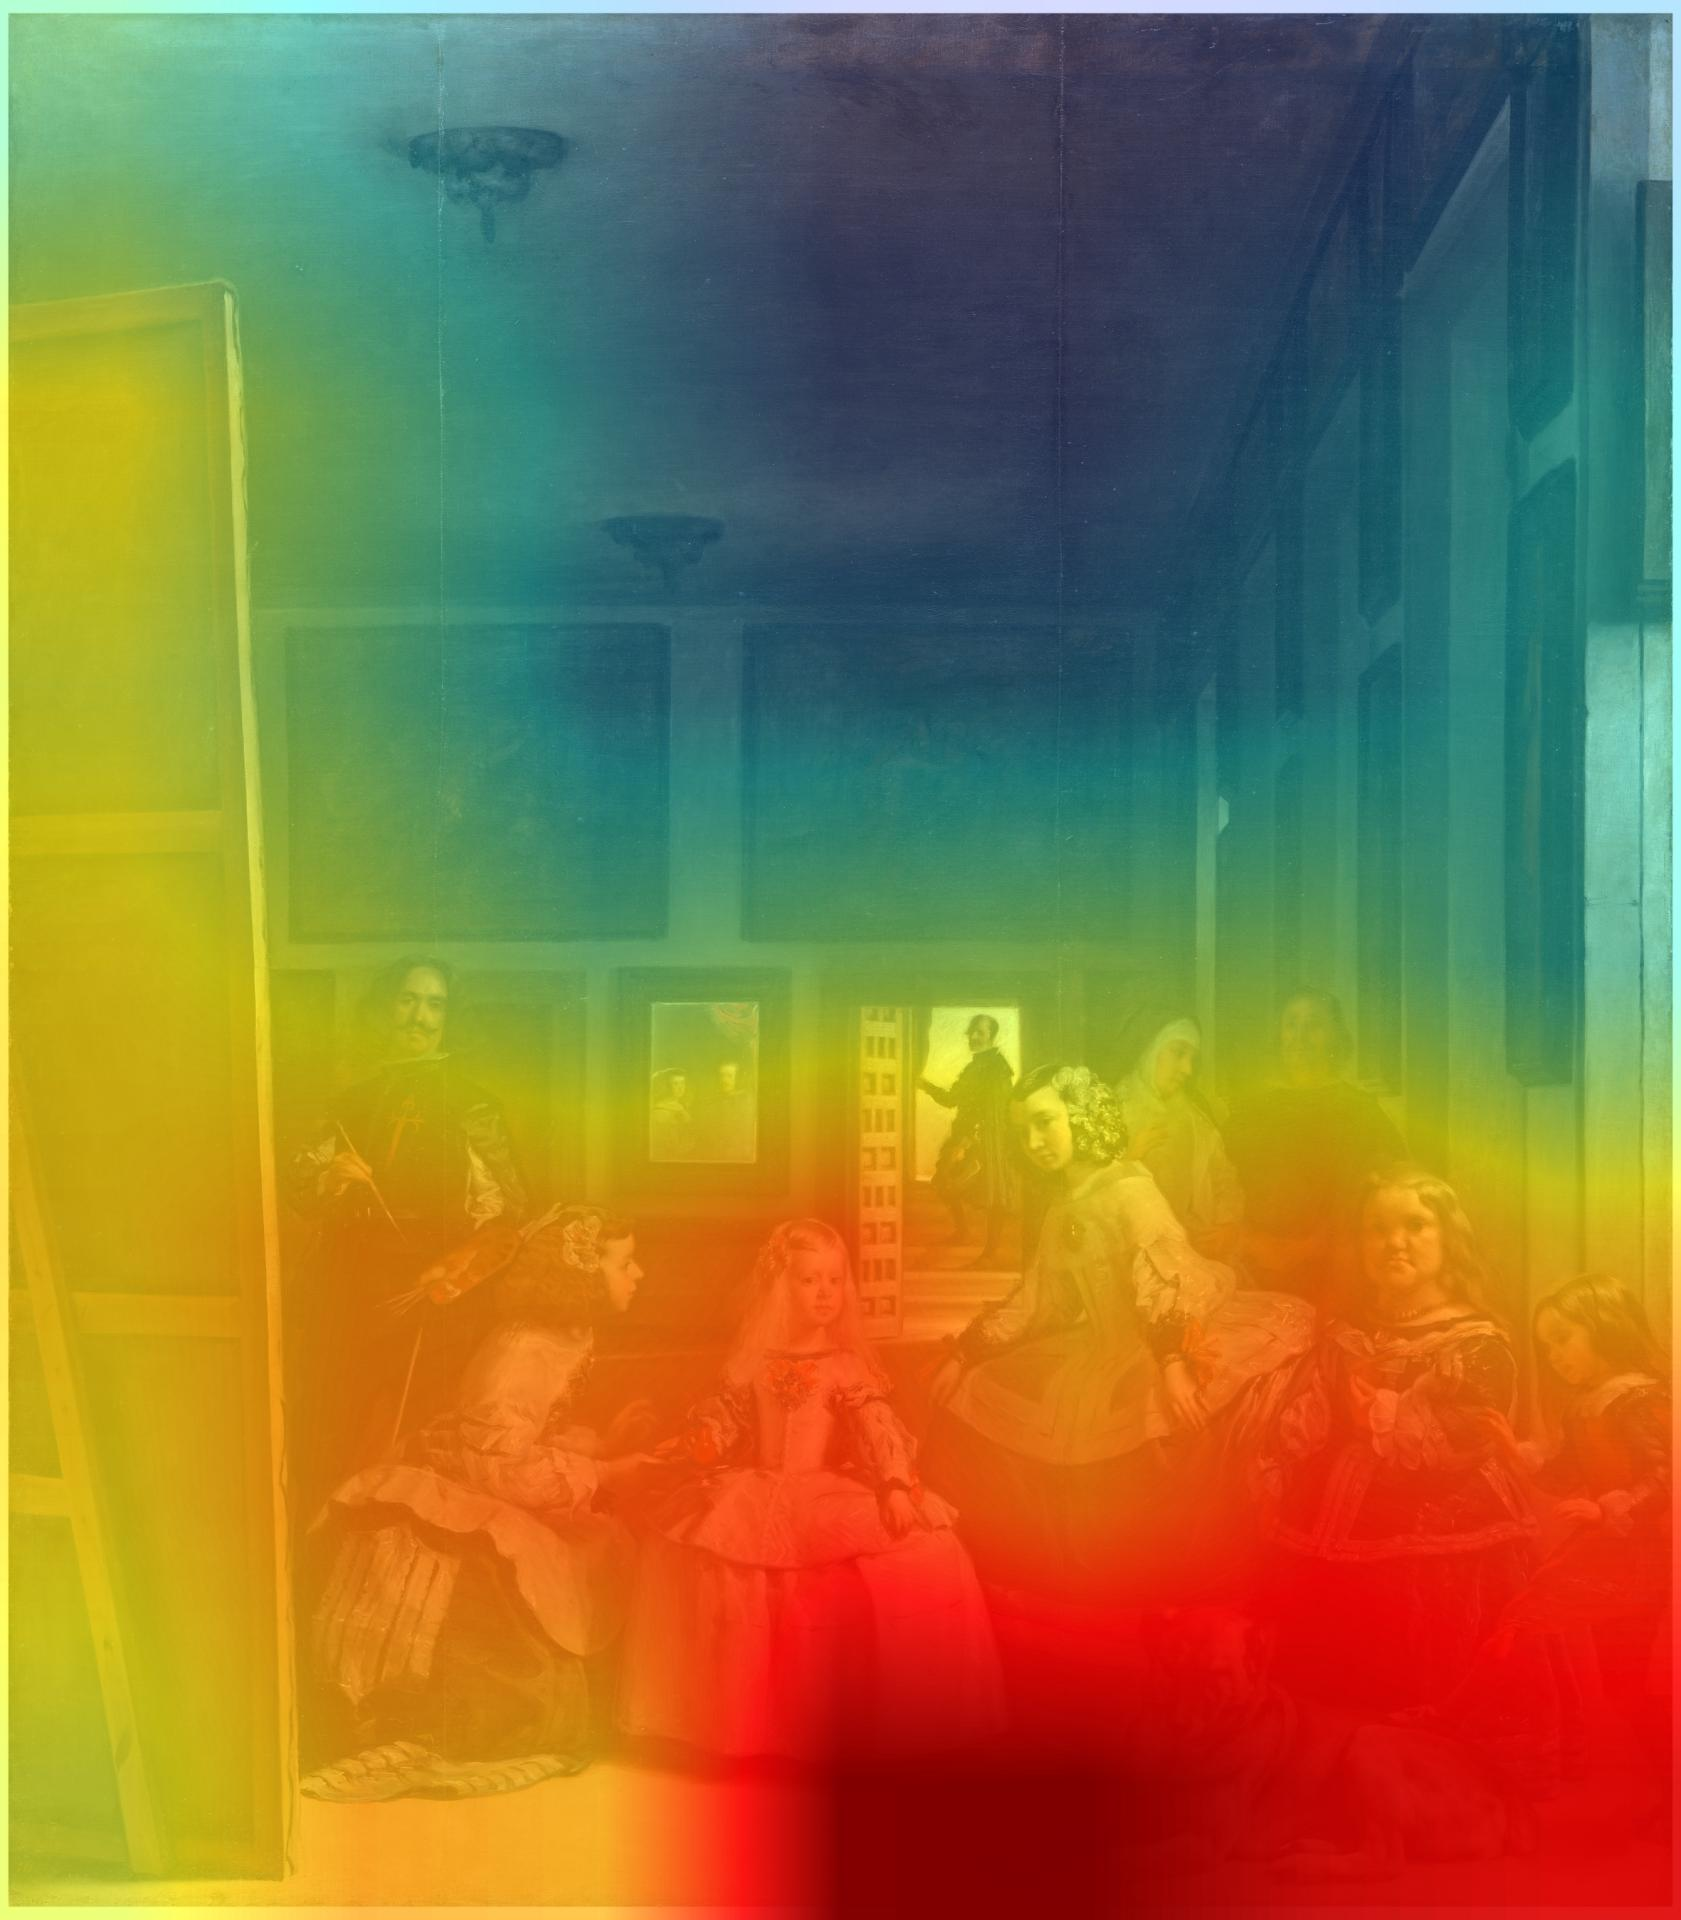

In [197]:
# img0 = load_image("test_images/american_gothic.jpg").to(device)

culture = "american"
image_index = "442"

img0 = PIL.Image.open("test_images/las_meninas.jpg").convert("RGB")
# img0 = PIL.Image.open("./data/art_culture_all_filtered/" + culture + "/" + str(image_index) + ".jpg").convert("RGB")
img_numpy = np.array(img0)

feat = generate_featuremap_unit(model,0,img0)
im_final = visualize_featuremap(img_numpy,feat)
showarray(im_final)

### Miscellaneous

In [20]:
culture_categories = {
    0 : "american",
    1 : "british",
    2 : "chinese",
    3 : "dutch",
    4 : "flemish",
    5 : "french",
    6 : "german",
    7 : "indian",
    8 : "italian",
    9 : "japanese",
    10 : "spanish"
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('french',), ('american',), ('british',), ('dutch',), ('spanish',), ('german',), ('flemish',), ('italian',), ('japanese',), ('chinese',), ('indian',)]


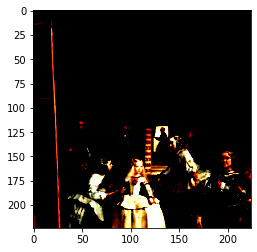

In [198]:
# Test on one specific example

# from torch.autograd import Variable
import matplotlib.pyplot as plt

def load_image(image_name):
    """Loads an image; returns a batched image tensor"""
    image = PIL.Image.open(image_name).convert("RGB")
#     plt.imshow(image)
    
    image = transform(image)
    
    plt.imshow(image.permute(1,2,0))
    
    image = image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image


def classify_image(model, categories, image_name):
    '''Classify an image using a specified model'''
    model.eval()
    image = load_image(image_name).to(device)
    result_vec = model(image)
    
    results = result_vec.sort(descending=True)[1][0].tolist()
#     top_result = result_vec.argmax(dim=-1).item()
    
    return [(categories[index],) for index in results]

model = initialize_model(num_classes=11,
                         resume_from="./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30").to(device)

culture = "spanish"
image_index = "27"

print(classify_image(model,
                     culture_categories,
                     "test_images/las_meninas.jpg"))

# print(classify_image(model,
#                      culture_categories,
#                      "./data/art_culture_test/" + culture + "/" + str(image_index) + ".jpg"))

In [ ]:
# Get testing data from directory
letters_val = torchvision.datasets.ImageFolder(root="./data/text_val",
                                               transform=transform)

letters_val_loader = torch.utils.data.DataLoader(dataset=letters_val,
                                                 batch_size=512,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

# Initialize model
model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet50(pretrained=False)

# Set number of output classes
model.conv1 = nn.Conv2d(in_channels=3,
                        out_channels=64,
                        kernel_size=(7,7),
                        stride=(2,2),
                        padding=(3,3),
                        bias=False)

in_features = model.fc.in_features
out_features = 26
model.fc = nn.Linear(in_features, out_features)

model = model.to(device)
model.load_state_dict(torch.load("./models/letter_model_lr01_gamma015_e12"))

val_acc = evaluate(model, letters_val_loader) * 100
print("Done!", val_acc)